# Вам предстоит решать задачу классификации изображений методом логистической регрессии. 

В итоге вы должны получить  функцию $f(x) \to [0,1]^{10}$, которая на вход получает картинку с написанной от руки цифрой, а на выход дает 10 вероятностей от 0 до 1 принадлежности к каждому из классов (цифре). Картинка это вектор из (8*8) = 64 чисел. Мы будем рассматривать параметрическое семейство функций $F(c)$, таких,  что если $f_с \in F$, то она удовлетворяет нашим требованиям. Кроме того, для каждой функции  $f_c \in F$ мы можем посчитать, насколько она хорошо работает на некотором наборе картинок - это будет функционал качества этой функции $loss(f_c, images)$. Чем он меньше, тем лучше: в идеале $loss$ будет давать $0$ в том случае, если наша функция на всех картинках, на которых нарисована цифра $i$ выдала вектор, где все числа отличны от $1$ и только на $i-м$ месте стоит $1$. Иначе это будет некоторое положительное число, которое тем больше, чем хуже работает классификатор (потеря)

Итак, возьмем функцию $g(c) = loss(f_c, images)$ и будем ее минимизировать. Если мы найдем глобальный минимум, то научимся максимально качественно решать задачу классификации с помощью того семейства функций, которое мы выбрали. Глобальный минимум мы, конечно, не сможем аналитически найти, поэтому будем решать задачу минимизации методом градиентного спуска.

# Возьмем датасет нарисованных от руки картинок

In [1]:

import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import math
from sklearn.datasets import load_digits
from sklearn.cross_validation import train_test_split
import tqdm 

digits = load_digits()

/home/user/study/OptimizationMethods/lin_prog/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
digits.data.shape

(1797, 64)

# Пример содержимого датасета

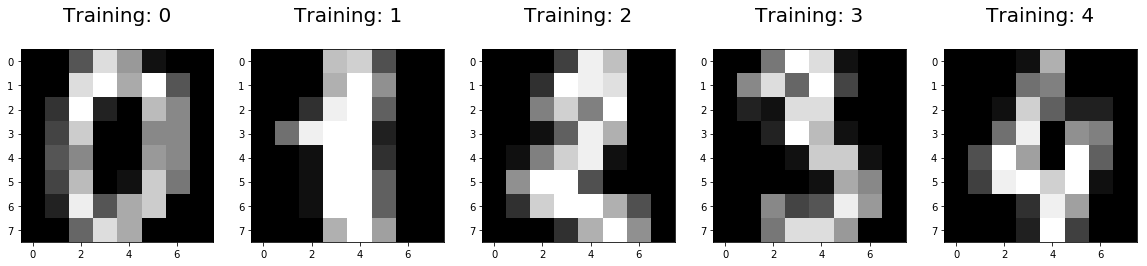

In [3]:
plt.figure(figsize=(20, 4))

for index, (image, label) in enumerate(zip(digits.data[0:5], digits.target[0:5])):
    plt.subplot(1, 5, index+1)
    plt.imshow(np.reshape(image, (8, 8)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)

# Разделим датасет на 2 части - train и validate
1. На первой мы будем решать оптимизационную задачу - искать такую функцию, которая по картинке выдает правильную цифру. 
2. На второй будем независимо проверять, насколько качественно работает наша функция

Это необходимо для того, чтобы понимать, насколько наша функция реально умеет решать поставленную задачу: понимать, где какая цифра. У нас ограниченная выборка - всего 1797 картинок. Но в реальности нарисованных цифр может быть значительно больше! Если даже наша функция безошибочно работает на всех 1797 картинках, но ошибается вне - это плохо. Обычно график обучения должен выглядит примерно так, если зеленое - обучающая выборка, а красное - валидационная

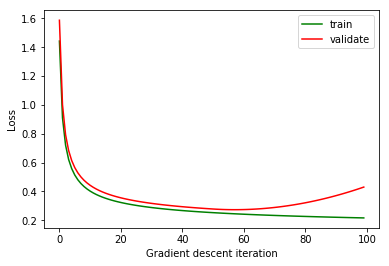

In [4]:
plt.plot(
    [1/math.log(i+2) for i in range(100)], 
    color='green', 
    label='train'
)

plt.plot(
    [1/math.log(i+2)*1.1+( (i/50.0-1)**2./5. if i>50 else 0.) for i in range(100)],
    color='red',
    label='validate')

plt.xlabel('Gradient descent iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

То есть с каждым шагом мы уменьшаем наш loss на обучающей выборке за счет градиентного спуска, но в какой-то момент функция может начать хорошо работать только на обучающей выборке. Этот эффект (в данном примере около 55 итерации по оси x) назвается переобучением.

# Вернемся к задаче
## Преобразуем числа от 0 до 9 в вектора из 10 элементов, где на i-m месте стоит 1, если цифра равна i и 0 иначе. 

## Также нормализуем картинки: все пиксели - это числа от 0 до 16. Сделаем их от -1 до 1, это улучшит качество нашей модели

In [5]:
def one_hot(y, n_classes):
    # делаем вектор из 10 координат с 0 везде кроме правильного ответа
    tmp = np.zeros(
        (len(y), n_classes), 
        dtype=np.uint8
    )
    tmp[range(len(tmp)), y] = 1
    return tmp

x_train, x_test, y_train, y_test = train_test_split(
    (digits.data - 8) / 8, 
    one_hot(digits.target, 10),
    test_size=0.33, 
    random_state=0
)

# Задание: реализовать методом градиентного спуска логистическую регрессию. Начиная с этой ячейки и ниже разрешено использовать только стандартные функции  python и библиотеки numpy и  matplotlib

Для каждой картинки (картинка представляет из себя вектор $x \in [-1, 1]^{64}$) мы хотим найти вектор $p = (p_0,\ldots,p_{9}) \in [0, 1]^{10}$, вероятностей, такой, что $p_i$ - вероятность того, что на картинка цифра $i$.

Реализуя логистическую регрессию, мы хотим приближать вероятности к их настоящему распределению. 

Выражение выдает ответ вида 
$$
A x + b
$$


где $x$ - наш вектор картинки, а результат - числовой вектор размерности $10$ с какими-то числами (в сумме не обязательно дают единицу). Для того, чтобы эти числа стали вероятностями от 0 до 1, реализуем функцию 
$$
softmax(x) = \frac{e^x}{\sum(e^x)}
$$
и полученные значения будут как раз давать в сумме 1 и ими мы будем приближать вероятности. 

Оценивать качество нашей модели будем с помощью кросс-энтропии, см https://en.wikipedia.org/wiki/Cross_entropy .
Пусть $L$ - функция потерь, тогда $L$ вычисляется по предсказанию $p$ и вектору-цифре $y$ по закону:
$$ L = -\sum_{i=0}^{9} y_i \cdot \ln{p_i}$$

In [7]:
def softmax(W, b, x):
    #todo - а можно ли написать лучше? и чем ваше решение лучше?
    if len(x.shape) >= 2:
        tmp = np.exp(np.dot(x, W.T) + b)
        return (tmp.T / tmp.sum(axis=1)).T
    else:
        tmp = np.exp(np.dot(x, W.T) + b)
        return (tmp.T / tmp.sum()).T

# кросс-энтропия от предсказанного вектора pred и данного вектора y
def loss(y, pred):
    distance = - (y * np.log(pred)).sum()
    return distance

# В данной точке x нужно научиться считать градиент. Выведите правила и посчитайте градиент в точке. Для того, чтобы выбирать градиент по всем точкам, можно его усреднить.

Параметры, которые мы можем варьировать для уменьшения функции потерь - это матрица $A = (a_{ij})$ и вектор $b$. Обозначим 
$$t = Ax + b,$$
Тогда $p_i = softmax(t_i)$, в свою очередь функция потерь $L$ - функция вектора-предсказания $p$ и настоящего числа, изображенного на данной картинке, то есть вектора $y$. Пусть для удобства $A_i$ - это $i$-я строка матрицы $A$ ($A \in Mat_{10 \times 64}$). Тогда $t_k = A_k x + b_k$. Предварительно вычислим некоторые частные производные:
$$\frac{\partial t_k}{\partial a_{ij}} =  
    \begin{cases}
        x_j,\; \text{если}\; k = i, \\
        0,\; \text{если}\; k \neq i,
    \end{cases}$$
$$\frac{\partial t_k}{\partial b_{i}} =  
    \begin{cases}
        1,\; \text{если}\; k = i, \\
        0,\; \text{если}\; k \neq i,
    \end{cases}$$
$$\frac{\partial p_n}{\partial t_{k}} = 
    \frac{\partial \left( \frac{e^{t_n}}{\sum e^{t_i}} \right)}{\partial t_{k}} =
    \frac{\partial \left(\frac{e^{t_n}}{\partial t_i}\right) \left(\sum e^{t_i} \right) - e^{t_n}e^{t_k}}{\left(\sum e^{t_i} \right)^2} = 
    \begin{cases}
        p_n (1 - p_n),\; \text{если}\; n = k, \\
        - p_n p_k,\; \text{если}\; n \neq k,
    \end{cases}$$
Теперь перейдем к вычислению частных производных, входящих в градиент в явном виде:
$$\frac{\partial L}{\partial a_{ij}} =
    \sum_{n = 0}^{9} \frac{\partial L}{\partial p_n} \frac{\partial p_n}{\partial a_{ij}} =
    \sum_{n = 0}^{9} \left( - \frac{y_n}{p_n} \right) \frac{\partial p_n}{\partial a_{ij}} =
    -\sum_{n = 0}^{9} \left( \frac{y_n}{p_n} \right) \sum_{k = 0}^{9} \frac{\partial p_n}{\partial t_k} \frac{\partial t_k}{\partial a_{ij}} =
    -\sum_{n = 0}^{9} \left( \frac{y_n}{p_n} \right) \frac{\partial p_n}{\partial t_i} \frac{\partial t_i}{\partial a_{ij}} = \\
    = -\sum_{n = 0}^{9} \left( \frac{y_n}{p_n} \right) \frac{\partial p_n}{\partial t_i} x_j =
    -x_j \left[ \frac{y_i}{p_i} \cdot p_i(1 - p_i) + \sum_{n \neq i} \frac{y_n}{p_n} \cdot (-p_n p_i) \right] = \\
    = -x_j \left[ y_i \cdot (1 - p_i) + \sum_{n \neq i} y_n \cdot (- p_i) \right]
    x_j \left[p_i \sum_{n =0}^{9} y_n  - y_i \right] = x_j (p_i - y_i).
$$

$$\frac{\partial L}{\partial b_i} =
    \sum_{n = 0}^{9} \frac{\partial L}{\partial p_n} \frac{\partial p_n}{\partial b_i} =
    \sum_{n = 0}^{9} \left( - \frac{y_n}{p_n} \right) \frac{\partial p_n}{\partial b_i} =
    -\sum_{n = 0}^{9} \left( \frac{y_n}{p_n} \right) \sum_{k = 0}^{9} \frac{\partial p_n}{\partial t_k} \frac{\partial t_k}{\partial b_i} =
    -\sum_{n = 0}^{9} \left( \frac{y_n}{p_n} \right) \frac{\partial p_n}{\partial t_i} \frac{\partial t_i}{\partial b_i}= \\
    = -\sum_{n = 0}^{9} \left( \frac{y_n}{p_n} \right) \frac{\partial p_n}{\partial t_i} \cdot 1 =
    - \left[ \frac{y_i}{p_i} \cdot p_i(1 - p_i) + \sum_{n \neq i} \frac{y_n}{p_n} \cdot (-p_n p_i) \right] = \\
    = - \left[ y_i \cdot (1 - p_i) + \sum_{n \neq i} y_n \cdot (- p_i) \right]
    \left[p_i \sum_{n =0}^{9} y_n  - y_i \right] = p_i - y_i.
$$
В итоге, интересующие нас производные получились равны:
$$  \boxed{ \frac{\partial L}{\partial a_{ij}} = x_j (p_i - y_i) } \;
    \boxed{ \frac{\partial L}{\partial b_i} = p_i - y_i }
$$

In [8]:
# Расчитываем градиент в данной точке x. pred - наше предсказание (вектор p)
def compute_gradients(pred, y, x):
    dW = np.dot(np.array([pred - y]).T, np.array([x]))
    db = pred - y
    gradient = np.append(dW, db)
    return gradient
#     m = y.shape[0]
#     n = x.shape[0]
#     gradient = np.zeros(m * n + m)
#     for k in range(m * n):
#         i = k // n
#         j = k % n
#         gradient[k] = x[j] * (pred[i] - y[i])
#     for k in range(m * n, len(gradient)):
#         i = k - m * n
#         gradient[k] = pred[i] - y[i]
#     return gradient

# Усредняем по всем точкам. x - множество точек; pred, y - соответсвующие x'ам предсказания и ответы. 
def gradients(pred, x, y):
    grads = [ compute_gradients(a, b, c) for a, b, c in zip(pred, y, x) ]                         
    return np.mean(grads, axis=0).T.flatten()    

# Методом градиентного спуска с постоянным шагом минимизируйте loss на обучающей выборке.

In [9]:
# Реализация градиентного спуска

# шаг спуска
eta = 1

# Определяем размерность параметров. Сколько их всего?
m = y_train[0].shape[0]
n = x_train[0].shape[0]
W = np.zeros((m, n))
b = np.zeros(m)

#будем записывать среднее значение потери на каждом шаге спуска
losses_train=[]
losses_valid=[]

#собственно сам спуск
iterations = 5000
for i in tqdm.tqdm(range(iterations)):
    p_train = softmax(W, b, x_train)
    p_test = softmax(W, b, x_test)
    loss_avg_train = np.average([ loss(y, p) for y, p in zip(y_train, p_train) ])
    losses_train.append(loss_avg_train)
    loss_avg_test = np.average([ loss(y, p) for y, p in zip(y_test, p_test) ])
    losses_valid.append(loss_avg_test)
    direction = gradients(p_train, x_train, y_train)
    W -= eta * direction[:m * n].reshape((m, n))
    b -= eta * direction[m * n:]

100%|██████████| 5000/5000 [11:48<00:00,  7.06it/s]


In [10]:
losses_train

[2.3025850929940459,
 1.5833935260184131,
 1.178173997323201,
 0.97508812627144625,
 0.92856525133682721,
 0.86310381755720977,
 0.89201785193314298,
 0.72071733970675467,
 0.66294308782494116,
 0.59335027145824448,
 0.5328687907581543,
 0.48204063310560202,
 0.42814577643041407,
 0.39402165067717382,
 0.36020910199367356,
 0.34058203236503692,
 0.32186031026424844,
 0.30941617743140509,
 0.29784985695246141,
 0.28867616866083018,
 0.28036668860481251,
 0.27307505310698332,
 0.26641418343274287,
 0.2603026878407852,
 0.25462449839582513,
 0.24931915493417833,
 0.24433823037425639,
 0.2396466078885576,
 0.23521573784553748,
 0.23102176053777843,
 0.22704404661866695,
 0.22326450472997836,
 0.21966711041758635,
 0.21623759274215965,
 0.2129631863886097,
 0.20983243324216569,
 0.2068350154826227,
 0.20396161482069008,
 0.20120379227418753,
 0.19855388517181988,
 0.1960049184433208,
 0.1935505279388938,
 0.19118489389027535,
 0.1889026829720202,
 0.18669899768219159,
 0.18456933197775305,


# Нарисуйте графики ошибки (loss) от номера шага градиентного спуска. Как падала ошибка на обучающей и тестовой выборках? На каком шаге ошибка на обучающей выборке оказалась минимальной?

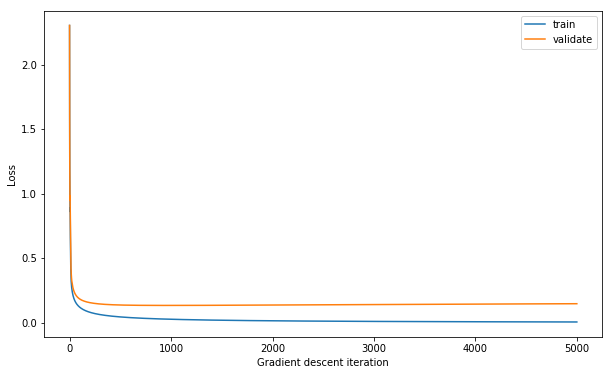

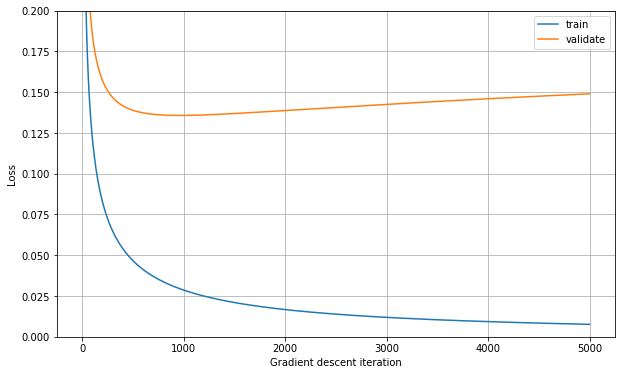

In [25]:
for i in range(2):
    plt.figure(figsize=(10, 6))
    plt.plot(range(iterations), losses_train, label='train')
    plt.plot(range(iterations), losses_valid, label='validate')
    plt.xlabel('Gradient descent iteration')
    plt.ylabel('Loss')
    if i == 1:
        plt.ylim(0, 0.2)
        plt.grid(True)
    plt.legend()
    plt.show()

[0 0 1 0 0 0 0 0 0 0]
[  3.32884733e-09   1.08017515e-02   9.88967839e-01   1.28259488e-10
   2.14230830e-05   6.68089485e-15   2.52300856e-09   2.00659861e-04
   8.32004112e-06   1.09996091e-14]


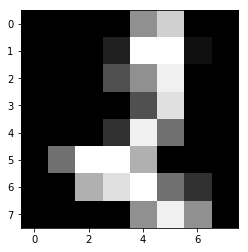

In [12]:
number = 28
x = x_train[number]
y = y_train[number]
plt.imshow(np.reshape(x, (8, 8)), cmap=plt.cm.gray)
p = softmax(W, b, x)
print(y)
print(p)

In [27]:
print("Train sample")
for i in range(iterations-1):
    if losses_train[i] < losses_train[i+1]:
        print(i)
np.argmin(losses_train)

Train sample
5


4999

In [24]:
print(u"Минимум ошибки для тестовой выборки наблюдается на {} итерации".format(np.argmin(losses_valid)))

Минимум ошибки для тестовой выборки наблюдается на 962 итерации


Можно сделать вывод, что ошибка (среднее значение функции потерь) на обучающей выборке постоянно падала почти с каждым шагом градиентного метода. Для тестовой выборки функция ошибки вначале также падала, но после приблизительно 1000 итерации стала возрастать, то есть начало наблюдаться переобучение.

# Реализуйте выбор шага градиентного спуска методом Армихо. Ускорило ли использование метода Армихо с начальными параметрами
$$ s=100, \beta=\alpha=0.5$$
# достижение минимума на обучающей выборке по сравнению с фиксированным шагом 100? А на валидационной?

In [13]:
def armijo (W, b, x, y, dW, db, alpha=0.5, beta=0.5):
    pass

# Какую долю картинок из валидационной выборки удается предсказать правильно? Приведите примеры из валидационной выборки, где модель ошибается и где работает правильно